In [99]:
import argparse
import os
import sys
import time

import numpy as np
import pandas as pd
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping
import torch
import yaml
from deepchoice.data import ChoiceDataset
from deepchoice.data.utils import create_data_loader
from deepchoice.model.bemb_flex_lightning import LitBEMBFlex
from sklearn.preprocessing import LabelEncoder
from termcolor import cprint

from tqdm import tqdm
from torch.distributions.multivariate_normal import MultivariateNormal
from deepchoice.model import BEMBFlex

import argparse
import os
import sys
import time

import numpy as np
import pandas as pd
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping
from ray import tune
from ray.tune import CLIReporter
from ray.tune.integration.pytorch_lightning import TuneReportCallback
from ray.tune.schedulers import ASHAScheduler
from pytorch_lightning.loggers import TensorBoardLogger
import torch
import yaml
from deepchoice.data import ChoiceDataset
from deepchoice.data.utils import create_data_loader
from deepchoice.model.bemb_flex_lightning import LitBEMBFlex
from sklearn.preprocessing import LabelEncoder
from termcolor import cprint

from deepchoice.model import BEMBFlex

import seaborn as sns


# The Simulation Study for Quick Checks on the Correctness of Algorithm: Define the data-generating-process (DGP)

$$
U_{uit} = \theta_i^\top \beta_u P
$$

$$
\theta_i \sim \mathcal{N}
$$

$$
\beta_u \sim \mathcal{N}
$$

In [121]:
NUM_USERS = 5
NUM_ITEMS = 20
NUM_SESSIONS = 10
K = 5
N = 1000
NUM_P_DIM = 3

In [122]:
user_mean = torch.randn((NUM_USERS, K * NUM_P_DIM))
item_mean = - torch.randn((NUM_ITEMS, K * NUM_P_DIM))

In [123]:
theta_dist = MultivariateNormal(loc=item_mean, covariance_matrix=torch.eye(K * NUM_P_DIM))
theta = theta_dist.sample()
theta = theta.reshape(NUM_ITEMS, K, NUM_P_DIM)

beta_dist = MultivariateNormal(loc=user_mean, covariance_matrix=torch.eye(K * NUM_P_DIM))
beta = beta_dist.sample()
beta = beta.reshape(NUM_USERS, K, NUM_P_DIM)

In [124]:
user_index = torch.LongTensor(np.random.choice(range(NUM_USERS), size=N, replace=True))
session_index = torch.LongTensor(np.random.choice(range(NUM_SESSIONS), size=N, replace=True))

In [125]:
P = torch.randn(size=(NUM_SESSIONS, NUM_ITEMS, NUM_P_DIM))

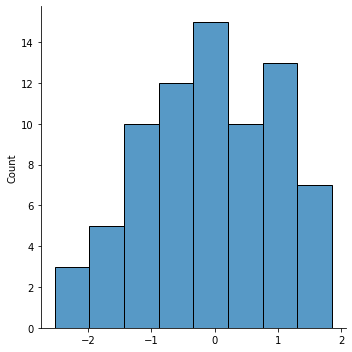

In [126]:
sns.displot(user_mean.reshape(-1,))

## Compute Utilities and Generate Labels

In [127]:
utility_array = list()
for row in tqdm(range(N)):
    u = user_index[row]
    t = session_index[row]
    utility = torch.zeros(NUM_ITEMS)
    for i in range(NUM_ITEMS):
        theta_i = theta[i]
        beta_u = beta[u]
        coef = (theta_i * beta_u).sum(dim=0)
        price = P[t, i, :]
        utility[i] = (coef * price).sum()
    utility_array.append(utility)

100%|██████████| 1000/1000 [00:00<00:00, 4366.91it/s]


In [128]:
U = torch.stack(utility_array)
label = torch.argmax(U, dim=1)

# Build Dataset

In [129]:
train_mask = np.arange(0, int(0.7*N))
val_mask = np.arange(int(0.7*N), int(0.85*N))
test_mask = np.arange(int(0.85*N), N)

dataset_list = list()
for mask in (train_mask, val_mask, test_mask):
    d = ChoiceDataset(label=label[mask],
                      user_index=user_index[mask],
                      session_index=session_index[mask],
                      item_availability=None,
                      price_obs=P)
    dataset_list.append(d)

In [130]:
class LitBEMBFlex(pl.LightningModule):
    def __init__(self, **kwargs):
        # use kwargs to pass parameter to BEMB Torch.
        super().__init__()
        self.model = BEMBFlex(**kwargs)
        self.num_needs = 4
        self.learning_rate = 0.03
        self.batch_size = 500

    def __str__(self) -> str:
        return str(self.model)

    def training_step(self, batch, batch_idx):
        elbo = self.model.elbo(batch, num_seeds=self.num_needs)
        self.log('train_elbo', elbo)
        loss = - elbo
        return loss

    def validation_step(self, batch, batch_idx):
        LL = self.model.forward(
            batch, return_logit=False, all_items=False).mean()
        self.log('val_log_likelihood', LL, prog_bar=True)

    def test_step(self, batch, batch_idx):
        LL = self.model.forward(
            batch, return_logit=False, all_items=False).mean()
        self.log('test_log_likelihood', LL)

        pred = self.model(batch)
        performance = self.model.get_within_category_accuracy(
            pred, batch.label)
        for key, val in performance.items():
            self.log('test_' + key, val, prog_bar=True)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

    def train_dataloader(self):
        return create_data_loader(dataset_list[0], batch_size=self.batch_size, shuffle=True, num_workers=8)

    def val_dataloader(self):
        return create_data_loader(dataset_list[1], batch_size=self.batch_size, shuffle=True, num_workers=8)

    def test_dataloader(self):
        # use smaller batch size for test, which takes more memory.
        return create_data_loader(dataset_list[2], batch_size=10000, shuffle=False, num_workers=8)

In [131]:
num_latents = 50

model = LitBEMBFlex(utility_formula='theta_item * beta_user * price_obs',
                    num_users=NUM_USERS,
                    num_items=NUM_ITEMS,
                    num_sessions=NUM_SESSIONS,
                    obs2prior_dict={'theta_item': False, 'beta_user': False},
                    coef_dim_dict={'theta_item': num_latents * NUM_P_DIM, 'beta_user': num_latents * NUM_P_DIM},
                    num_price_obs=NUM_P_DIM)
trainer = pl.Trainer(
    max_epochs=10,
    check_val_every_n_epoch=1,
    log_every_n_steps=1,
    gpus=1)
trainer.fit(model)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type     | Params
-----------------------------------
0 | model | BEMBFlex | 7.5 K 
-----------------------------------
7.5 K     Trainable params
0         Non-trainable params
7.5 K     Total params
0.030     Total estimated model params size (MB)


You are using BEMB Flex v3 (rc)
BEMB: utility formula parsed:
[{'coefficient': ['theta_item', 'beta_user'], 'observable': 'price_obs'}]


Validation sanity check: 0it [00:00, ?it/s]

Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [132]:
trainer.test(model)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.7866666913032532,
 'test_f1score': 0.7876542210578918,
 'test_log_likelihood': -1.9390641450881958,
 'test_precision': 0.8188446760177612,
 'test_recall': 0.758752703666687}
--------------------------------------------------------------------------------


[{'test_log_likelihood': -1.9390641450881958,
  'test_accuracy': 0.7866666913032532,
  'test_precision': 0.8188446760177612,
  'test_recall': 0.758752703666687,
  'test_f1score': 0.7876542210578918}]

In [133]:
num_epochs = 50

callback = TuneReportCallback({'val_log_likelihood': 'val_log_likelihood'}, on='validation_end')

def train_tune(hparams, epochs=10, gpus=1):
    model = LitBEMBFlex(utility_formula='theta_item * beta_user * price_obs',
                    num_users=NUM_USERS,
                    num_items=NUM_ITEMS,
                    num_sessions=NUM_SESSIONS,
                    obs2prior_dict={'theta_item': False, 'beta_user': False},
                    coef_dim_dict={'theta_item': hparams['num_latents'] * NUM_P_DIM, 'beta_user': hparams['num_latents'] * NUM_P_DIM},
                    num_price_obs=NUM_P_DIM)

    trainer = pl.Trainer(
        max_epochs=epochs,
        check_val_every_n_epoch=1,
        log_every_n_steps=1,
        gpus=gpus,
        progress_bar_refresh_rate=0,
        logger=TensorBoardLogger(save_dir=tune.get_trial_dir(), name='', version='.'),
        callbacks=[callback])
    trainer.fit(model)

In [ ]:
num_samples = 20

config = {
    'num_latents': tune.choice([1, 2, 3, 4, 5, 7, 10, 20, 50, 100, 300, 1000])
}

scheduler = ASHAScheduler(max_t=num_epochs, grace_period=1, reduction_factor=2)

reporter = CLIReporter(parameter_columns=list(config.keys()),
                       metric_columns=list(callback._metrics.keys()))

analysis = tune.run(
    tune.with_parameters(train_tune, epochs=num_epochs, gpus=1),
    metric='val_log_likelihood',
    mode='max',
    resources_per_trial={'cpu': 16, 'gpu': 1},
    config=config,
    num_samples=num_samples,
    scheduler=scheduler,
    progress_reporter=reporter)

print("Best hyperparameters found were: ", analysis.best_config)


== Status ==
Memory usage on this node: 8.4/125.5 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 32.000: None | Iter 16.000: None | Iter 8.000: None | Iter 4.000: None | Iter 2.000: None | Iter 1.000: None
Resources requested: 0/16 CPUs, 0/1 GPUs, 0.0/73.6 GiB heap, 0.0/35.54 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/tianyudu/ray_results/train_tune_2021-10-11_18-19-59
Number of trials: 17/20 (17 PENDING)
+------------------------+----------+-------+---------------+
| Trial name             | status   | loc   |   num_latents |
|------------------------+----------+-------+---------------|
| train_tune_84be5_00000 | PENDING  |       |            10 |
| train_tune_84be5_00001 | PENDING  |       |           100 |
| train_tune_84be5_00002 | PENDING  |       |             3 |
| train_tune_84be5_00003 | PENDING  |       |             4 |
| train_tune_84be5_00004 | PENDING  |       |            10 |
| train_tune_84be5_00005 | PENDING  |       |            10 |
| train

(pid=1039943) GPU available: True, used: True
(pid=1039943) TPU available: False, using: 0 TPU cores
(pid=1039943) IPU available: False, using: 0 IPUs
(pid=1039943) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(pid=1039943) 
(pid=1039943)   | Name  | Type     | Params
(pid=1039943) -----------------------------------
(pid=1039943) 0 | model | BEMBFlex | 1.5 K 
(pid=1039943) -----------------------------------
(pid=1039943) 1.5 K     Trainable params
(pid=1039943) 0         Non-trainable params
(pid=1039943) 1.5 K     Total params
(pid=1039943) 0.006     Total estimated model params size (MB)
(pid=1039943) /home/tianyudu/anaconda3/envs/ml/lib/python3.8/site-packages/pytorch_lightning/trainer/deprecated_api.py:25: LightningDeprecationWarning: `Trainer.running_sanity_check` has been renamed to `Trainer.sanity_checking` and will be removed in v1.5.
(pid=1039943)   rank_zero_deprecation(


== Status ==
Memory usage on this node: 12.3/125.5 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 32.000: None | Iter 16.000: None | Iter 8.000: None | Iter 4.000: None | Iter 2.000: None | Iter 1.000: None
Resources requested: 16.0/16 CPUs, 1.0/1 GPUs, 0.0/73.6 GiB heap, 0.0/35.54 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/tianyudu/ray_results/train_tune_2021-10-11_18-19-59
Number of trials: 18/20 (17 PENDING, 1 RUNNING)
+------------------------+----------+-------+---------------+
| Trial name             | status   | loc   |   num_latents |
|------------------------+----------+-------+---------------|
| train_tune_84be5_00000 | RUNNING  |       |            10 |
| train_tune_84be5_00001 | PENDING  |       |           100 |
| train_tune_84be5_00002 | PENDING  |       |             3 |
| train_tune_84be5_00003 | PENDING  |       |             4 |
| train_tune_84be5_00004 | PENDING  |       |            10 |
| train_tune_84be5_00005 | PENDING  |       |       

Result for train_tune_84be5_00000:
  date: 2021-10-11_18-20-16
  done: false
  experiment_id: 3ad9de640ef443238105c5e2caa5de50
  hostname: aurora
  iterations_since_restore: 17
  node_ip: 192.168.0.158
  pid: 1039943
  time_since_restore: 15.065951347351074
  time_this_iter_s: 0.6839993000030518
  time_total_s: 15.065951347351074
  timestamp: 1634001616
  timesteps_since_restore: 0
  training_iteration: 17
  trial_id: 84be5_00000
  val_log_likelihood: -1.0132337808609009
  
== Status ==
Memory usage on this node: 12.2/125.5 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 32.000: None | Iter 16.000: -1.0825423002243042 | Iter 8.000: -2.5817272663116455 | Iter 4.000: -4.776825904846191 | Iter 2.000: -6.445621013641357 | Iter 1.000: -7.3631062507629395
Resources requested: 16.0/16 CPUs, 1.0/1 GPUs, 0.0/73.6 GiB heap, 0.0/35.54 GiB objects (0.0/1.0 accelerator_type:G)
Current best trial: 84be5_00000 with val_log_likelihood=-0.5969322919845581 and parameters={'num_latents': 10}
Result

Result for train_tune_84be5_00000:
  date: 2021-10-11_18-20-32
  done: false
  experiment_id: 3ad9de640ef443238105c5e2caa5de50
  hostname: aurora
  iterations_since_restore: 41
  node_ip: 192.168.0.158
  pid: 1039943
  time_since_restore: 31.647354125976562
  time_this_iter_s: 0.6802787780761719
  time_total_s: 31.647354125976562
  timestamp: 1634001632
  timesteps_since_restore: 0
  training_iteration: 41
  trial_id: 84be5_00000
  val_log_likelihood: -0.10934583097696304
  
== Status ==
Memory usage on this node: 12.2/125.5 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 32.000: -0.281253457069397 | Iter 16.000: -1.0825423002243042 | Iter 8.000: -2.5817272663116455 | Iter 4.000: -4.776825904846191 | Iter 2.000: -6.445621013641357 | Iter 1.000: -7.3631062507629395
Resources requested: 16.0/16 CPUs, 1.0/1 GPUs, 0.0/73.6 GiB heap, 0.0/35.54 GiB objects (0.0/1.0 accelerator_type:G)
Current best trial: 84be5_00000 with val_log_likelihood=-0.023121792823076248 and parameters={'num_lat

(pid=1054171) GPU available: True, used: True
(pid=1054171) TPU available: False, using: 0 TPU cores
(pid=1054171) IPU available: False, using: 0 IPUs
(pid=1054171) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


(pid=1054171) You are using BEMB Flex v3 (rc)
(pid=1054171) BEMB: utility formula parsed:
(pid=1054171) [{'coefficient': ['theta_item', 'beta_user'], 'observable': 'price_obs'}]


(pid=1054171) 
(pid=1054171)   | Name  | Type     | Params
(pid=1054171) -----------------------------------
(pid=1054171) 0 | model | BEMBFlex | 15.0 K
(pid=1054171) -----------------------------------
(pid=1054171) 15.0 K    Trainable params
(pid=1054171) 0         Non-trainable params
(pid=1054171) 15.0 K    Total params
(pid=1054171) 0.060     Total estimated model params size (MB)


== Status ==
Memory usage on this node: 11.4/125.5 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 32.000: -0.281253457069397 | Iter 16.000: -1.0825423002243042 | Iter 8.000: -2.5817272663116455 | Iter 4.000: -4.776825904846191 | Iter 2.000: -6.445621013641357 | Iter 1.000: -7.3631062507629395
Resources requested: 16.0/16 CPUs, 1.0/1 GPUs, 0.0/73.6 GiB heap, 0.0/35.54 GiB objects (0.0/1.0 accelerator_type:G)
Current best trial: 84be5_00000 with val_log_likelihood=-0.013439194299280643 and parameters={'num_latents': 10}
Result logdir: /home/tianyudu/ray_results/train_tune_2021-10-11_18-19-59
Number of trials: 19/20 (17 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+-------+---------------+----------------------+
| Trial name             | status     | loc   |   num_latents |   val_log_likelihood |
|------------------------+------------+-------+---------------+----------------------|
| train_tune_84be5_00001 | RUNNING    |       |           100 |          

(pid=1054171) /home/tianyudu/anaconda3/envs/ml/lib/python3.8/site-packages/pytorch_lightning/trainer/deprecated_api.py:25: LightningDeprecationWarning: `Trainer.running_sanity_check` has been renamed to `Trainer.sanity_checking` and will be removed in v1.5.
(pid=1054171)   rank_zero_deprecation(


Result for train_tune_84be5_00001:
  date: 2021-10-11_18-20-44
  done: true
  experiment_id: 90a0c1712fd3444a981d6a0dae6daee9
  hostname: aurora
  iterations_since_restore: 1
  node_ip: 192.168.0.158
  pid: 1054171
  time_since_restore: 4.085261106491089
  time_this_iter_s: 4.085261106491089
  time_total_s: 4.085261106491089
  timestamp: 1634001644
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 84be5_00001
  val_log_likelihood: -25.585140228271484
  
(pid=1054643) You are using BEMB Flex v3 (rc)
(pid=1054643) BEMB: utility formula parsed:
(pid=1054643) [{'coefficient': ['theta_item', 'beta_user'], 'observable': 'price_obs'}]


(pid=1054643) GPU available: True, used: True
(pid=1054643) TPU available: False, using: 0 TPU cores
(pid=1054643) IPU available: False, using: 0 IPUs
(pid=1054643) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


== Status ==
Memory usage on this node: 11.1/125.5 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 32.000: -0.281253457069397 | Iter 16.000: -1.0825423002243042 | Iter 8.000: -2.5817272663116455 | Iter 4.000: -4.776825904846191 | Iter 2.000: -6.445621013641357 | Iter 1.000: -16.474123239517212
Resources requested: 16.0/16 CPUs, 1.0/1 GPUs, 0.0/73.6 GiB heap, 0.0/35.54 GiB objects (0.0/1.0 accelerator_type:G)
Current best trial: 84be5_00000 with val_log_likelihood=-0.013439194299280643 and parameters={'num_latents': 10}
Result logdir: /home/tianyudu/ray_results/train_tune_2021-10-11_18-19-59
Number of trials: 20/20 (17 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+-------+---------------+----------------------+
| Trial name             | status     | loc   |   num_latents |   val_log_likelihood |
|------------------------+------------+-------+---------------+----------------------|
| train_tune_84be5_00002 | RUNNING    |       |             3 |          

(pid=1054643) 
(pid=1054643)   | Name  | Type     | Params
(pid=1054643) -----------------------------------
(pid=1054643) 0 | model | BEMBFlex | 450   
(pid=1054643) -----------------------------------
(pid=1054643) 450       Trainable params
(pid=1054643) 0         Non-trainable params
(pid=1054643) 450       Total params
(pid=1054643) 0.002     Total estimated model params size (MB)
(pid=1054643) /home/tianyudu/anaconda3/envs/ml/lib/python3.8/site-packages/pytorch_lightning/trainer/deprecated_api.py:25: LightningDeprecationWarning: `Trainer.running_sanity_check` has been renamed to `Trainer.sanity_checking` and will be removed in v1.5.
(pid=1054643)   rank_zero_deprecation(


Result for train_tune_84be5_00002:
  date: 2021-10-11_18-20-49
  done: false
  experiment_id: acb3c244d748411cbf7f6380bf429d4f
  hostname: aurora
  iterations_since_restore: 1
  node_ip: 192.168.0.158
  pid: 1054643
  time_since_restore: 4.056497573852539
  time_this_iter_s: 4.056497573852539
  time_total_s: 4.056497573852539
  timestamp: 1634001649
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 84be5_00002
  val_log_likelihood: -5.045517921447754
  
== Status ==
Memory usage on this node: 12.2/125.5 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 32.000: -0.281253457069397 | Iter 16.000: -1.0825423002243042 | Iter 8.000: -2.5817272663116455 | Iter 4.000: -4.431471824645996 | Iter 2.000: -5.569539785385132 | Iter 1.000: -7.3631062507629395
Resources requested: 16.0/16 CPUs, 1.0/1 GPUs, 0.0/73.6 GiB heap, 0.0/35.54 GiB objects (0.0/1.0 accelerator_type:G)
Current best trial: 84be5_00000 with val_log_likelihood=-0.013439194299280643 and parameters={'num_latents': 

(pid=1057077) GPU available: True, used: True
(pid=1057077) TPU available: False, using: 0 TPU cores
(pid=1057077) IPU available: False, using: 0 IPUs
(pid=1057077) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(pid=1057077) 
(pid=1057077)   | Name  | Type     | Params
(pid=1057077) -----------------------------------
(pid=1057077) 0 | model | BEMBFlex | 600   
(pid=1057077) -----------------------------------
(pid=1057077) 600       Trainable params
(pid=1057077) 0         Non-trainable params
(pid=1057077) 600       Total params
(pid=1057077) 0.002     Total estimated model params size (MB)
(pid=1057077) /home/tianyudu/anaconda3/envs/ml/lib/python3.8/site-packages/pytorch_lightning/trainer/deprecated_api.py:25: LightningDeprecationWarning: `Trainer.running_sanity_check` has been renamed to `Trainer.sanity_checking` and will be removed in v1.5.
(pid=1057077)   rank_zero_deprecation(


Result for train_tune_84be5_00003:
  date: 2021-10-11_18-20-59
  done: false
  experiment_id: 002c57cbe52341d2844c1b9b495dac08
  hostname: aurora
  iterations_since_restore: 1
  node_ip: 192.168.0.158
  pid: 1057077
  time_since_restore: 4.06821084022522
  time_this_iter_s: 4.06821084022522
  time_total_s: 4.06821084022522
  timestamp: 1634001659
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 84be5_00003
  val_log_likelihood: -6.108400821685791
  
== Status ==
Memory usage on this node: 12.2/125.5 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 32.000: -0.281253457069397 | Iter 16.000: -1.0825423002243042 | Iter 8.000: -2.924723982810974 | Iter 4.000: -4.431471824645996 | Iter 2.000: -5.569539785385132 | Iter 1.000: -6.735753536224365
Resources requested: 16.0/16 CPUs, 1.0/1 GPUs, 0.0/73.6 GiB heap, 0.0/35.54 GiB objects (0.0/1.0 accelerator_type:G)
Current best trial: 84be5_00000 with val_log_likelihood=-0.013439194299280643 and parameters={'num_latents': 10}
R

(pid=1057829) GPU available: True, used: True
(pid=1057829) TPU available: False, using: 0 TPU cores
(pid=1057829) IPU available: False, using: 0 IPUs
(pid=1057829) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(pid=1057829) 
(pid=1057829)   | Name  | Type     | Params
(pid=1057829) -----------------------------------
(pid=1057829) 0 | model | BEMBFlex | 1.5 K 
(pid=1057829) -----------------------------------
(pid=1057829) 1.5 K     Trainable params
(pid=1057829) 0         Non-trainable params
(pid=1057829) 1.5 K     Total params
(pid=1057829) 0.006     Total estimated model params size (MB)
(pid=1057829) /home/tianyudu/anaconda3/envs/ml/lib/python3.8/site-packages/pytorch_lightning/trainer/deprecated_api.py:25: LightningDeprecationWarning: `Trainer.running_sanity_check` has been renamed to `Trainer.sanity_checking` and will be removed in v1.5.
(pid=1057829)   rank_zero_deprecation(


Result for train_tune_84be5_00004:
  date: 2021-10-11_18-21-05
  done: true
  experiment_id: aec8cbf0c9e14f599b83b13f59cf058d
  hostname: aurora
  iterations_since_restore: 1
  node_ip: 192.168.0.158
  pid: 1057829
  time_since_restore: 3.997380256652832
  time_this_iter_s: 3.997380256652832
  time_total_s: 3.997380256652832
  timestamp: 1634001665
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 84be5_00004
  val_log_likelihood: -9.618912696838379
  
== Status ==
Memory usage on this node: 12.1/125.5 GiB
Using AsyncHyperBand: num_stopped=5
Bracket: Iter 32.000: -0.281253457069397 | Iter 16.000: -1.0825423002243042 | Iter 8.000: -2.924723982810974 | Iter 4.000: -4.431471824645996 | Iter 2.000: -5.584064483642578 | Iter 1.000: -7.3631062507629395
Resources requested: 0/16 CPUs, 0/1 GPUs, 0.0/73.6 GiB heap, 0.0/35.54 GiB objects (0.0/1.0 accelerator_type:G)
Current best trial: 84be5_00000 with val_log_likelihood=-0.013439194299280643 and parameters={'num_latents': 10}
Res

(pid=1058295) GPU available: True, used: True
(pid=1058295) TPU available: False, using: 0 TPU cores
(pid=1058295) IPU available: False, using: 0 IPUs
(pid=1058295) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(pid=1058295) 
(pid=1058295)   | Name  | Type     | Params
(pid=1058295) -----------------------------------
(pid=1058295) 0 | model | BEMBFlex | 1.5 K 
(pid=1058295) -----------------------------------
(pid=1058295) 1.5 K     Trainable params
(pid=1058295) 0         Non-trainable params
(pid=1058295) 1.5 K     Total params
(pid=1058295) 0.006     Total estimated model params size (MB)
(pid=1058295) /home/tianyudu/anaconda3/envs/ml/lib/python3.8/site-packages/pytorch_lightning/trainer/deprecated_api.py:25: LightningDeprecationWarning: `Trainer.running_sanity_check` has been renamed to `Trainer.sanity_checking` and will be removed in v1.5.
(pid=1058295)   rank_zero_deprecation(


Result for train_tune_84be5_00005:
  date: 2021-10-11_18-21-10
  done: true
  experiment_id: 3ae2408d48924af7a6c1db8fef04fb2b
  hostname: aurora
  iterations_since_restore: 1
  node_ip: 192.168.0.158
  pid: 1058295
  time_since_restore: 3.992957830429077
  time_this_iter_s: 3.992957830429077
  time_total_s: 3.992957830429077
  timestamp: 1634001670
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 84be5_00005
  val_log_likelihood: -8.894775390625
  
== Status ==
Memory usage on this node: 12.1/125.5 GiB
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 32.000: -0.281253457069397 | Iter 16.000: -1.0825423002243042 | Iter 8.000: -2.924723982810974 | Iter 4.000: -4.431471824645996 | Iter 2.000: -5.584064483642578 | Iter 1.000: -8.12894082069397
Resources requested: 0/16 CPUs, 0/1 GPUs, 0.0/73.6 GiB heap, 0.0/35.54 GiB objects (0.0/1.0 accelerator_type:G)
Current best trial: 84be5_00000 with val_log_likelihood=-0.013439194299280643 and parameters={'num_latents': 10}
Result l

(pid=1058767) GPU available: True, used: True
(pid=1058767) TPU available: False, using: 0 TPU cores
(pid=1058767) IPU available: False, using: 0 IPUs
(pid=1058767) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


(pid=1058767) You are using BEMB Flex v3 (rc)
(pid=1058767) BEMB: utility formula parsed:
(pid=1058767) [{'coefficient': ['theta_item', 'beta_user'], 'observable': 'price_obs'}]


(pid=1058767) 
(pid=1058767)   | Name  | Type     | Params
(pid=1058767) -----------------------------------
(pid=1058767) 0 | model | BEMBFlex | 3.0 K 
(pid=1058767) -----------------------------------
(pid=1058767) 3.0 K     Trainable params
(pid=1058767) 0         Non-trainable params
(pid=1058767) 3.0 K     Total params
(pid=1058767) 0.012     Total estimated model params size (MB)
(pid=1058767) /home/tianyudu/anaconda3/envs/ml/lib/python3.8/site-packages/pytorch_lightning/trainer/deprecated_api.py:25: LightningDeprecationWarning: `Trainer.running_sanity_check` has been renamed to `Trainer.sanity_checking` and will be removed in v1.5.
(pid=1058767)   rank_zero_deprecation(


Result for train_tune_84be5_00006:
  date: 2021-10-11_18-21-16
  done: true
  experiment_id: ca664ce6b61c45399fd866fd4af99e31
  hostname: aurora
  iterations_since_restore: 1
  node_ip: 192.168.0.158
  pid: 1058767
  time_since_restore: 4.009984731674194
  time_this_iter_s: 4.009984731674194
  time_total_s: 4.009984731674194
  timestamp: 1634001676
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 84be5_00006
  val_log_likelihood: -15.803245544433594
  
== Status ==
Memory usage on this node: 12.2/125.5 GiB
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 32.000: -0.281253457069397 | Iter 16.000: -1.0825423002243042 | Iter 8.000: -2.924723982810974 | Iter 4.000: -4.431471824645996 | Iter 2.000: -5.584064483642578 | Iter 1.000: -8.894775390625
Resources requested: 0/16 CPUs, 0/1 GPUs, 0.0/73.6 GiB heap, 0.0/35.54 GiB objects (0.0/1.0 accelerator_type:G)
Current best trial: 84be5_00000 with val_log_likelihood=-0.013439194299280643 and parameters={'num_latents': 10}
Result

(pid=1059236) GPU available: True, used: True
(pid=1059236) TPU available: False, using: 0 TPU cores
(pid=1059236) IPU available: False, using: 0 IPUs
(pid=1059236) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(pid=1059236) 
(pid=1059236)   | Name  | Type     | Params
(pid=1059236) -----------------------------------
(pid=1059236) 0 | model | BEMBFlex | 1.5 K 
(pid=1059236) -----------------------------------
(pid=1059236) 1.5 K     Trainable params
(pid=1059236) 0         Non-trainable params
(pid=1059236) 1.5 K     Total params
(pid=1059236) 0.006     Total estimated model params size (MB)
(pid=1059236) /home/tianyudu/anaconda3/envs/ml/lib/python3.8/site-packages/pytorch_lightning/trainer/deprecated_api.py:25: LightningDeprecationWarning: `Trainer.running_sanity_check` has been renamed to `Trainer.sanity_checking` and will be removed in v1.5.
(pid=1059236)   rank_zero_deprecation(


Result for train_tune_84be5_00007:
  date: 2021-10-11_18-21-21
  done: true
  experiment_id: 2acc937ce5054373b8068f0477b61bc1
  hostname: aurora
  iterations_since_restore: 1
  node_ip: 192.168.0.158
  pid: 1059236
  time_since_restore: 3.995650053024292
  time_this_iter_s: 3.995650053024292
  time_total_s: 3.995650053024292
  timestamp: 1634001681
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 84be5_00007
  val_log_likelihood: -10.072299003601074
  
== Status ==
Memory usage on this node: 12.2/125.5 GiB
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 32.000: -0.281253457069397 | Iter 16.000: -1.0825423002243042 | Iter 8.000: -2.924723982810974 | Iter 4.000: -4.431471824645996 | Iter 2.000: -5.584064483642578 | Iter 1.000: -9.25684404373169
Resources requested: 0/16 CPUs, 0/1 GPUs, 0.0/73.6 GiB heap, 0.0/35.54 GiB objects (0.0/1.0 accelerator_type:G)
Current best trial: 84be5_00000 with val_log_likelihood=-0.013439194299280643 and parameters={'num_latents': 10}
Resu

(pid=1059715) GPU available: True, used: True
(pid=1059715) TPU available: False, using: 0 TPU cores
(pid=1059715) IPU available: False, using: 0 IPUs
(pid=1059715) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


(pid=1059715) You are using BEMB Flex v3 (rc)
(pid=1059715) BEMB: utility formula parsed:
(pid=1059715) [{'coefficient': ['theta_item', 'beta_user'], 'observable': 'price_obs'}]


(pid=1059715) 
(pid=1059715)   | Name  | Type     | Params
(pid=1059715) -----------------------------------
(pid=1059715) 0 | model | BEMBFlex | 300   
(pid=1059715) -----------------------------------
(pid=1059715) 300       Trainable params
(pid=1059715) 0         Non-trainable params
(pid=1059715) 300       Total params
(pid=1059715) 0.001     Total estimated model params size (MB)
(pid=1059715) /home/tianyudu/anaconda3/envs/ml/lib/python3.8/site-packages/pytorch_lightning/trainer/deprecated_api.py:25: LightningDeprecationWarning: `Trainer.running_sanity_check` has been renamed to `Trainer.sanity_checking` and will be removed in v1.5.
(pid=1059715)   rank_zero_deprecation(


Result for train_tune_84be5_00008:
  date: 2021-10-11_18-21-26
  done: false
  experiment_id: 7addb37cbad849de9ecb8b6350df19c0
  hostname: aurora
  iterations_since_restore: 1
  node_ip: 192.168.0.158
  pid: 1059715
  time_since_restore: 4.011392116546631
  time_this_iter_s: 4.011392116546631
  time_total_s: 4.011392116546631
  timestamp: 1634001686
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 84be5_00008
  val_log_likelihood: -5.595610618591309
  
== Status ==
Memory usage on this node: 12.2/125.5 GiB
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 32.000: -0.281253457069397 | Iter 16.000: -1.0825423002243042 | Iter 8.000: -2.924723982810974 | Iter 4.000: -4.431471824645996 | Iter 2.000: -5.584064483642578 | Iter 1.000: -8.894775390625
Resources requested: 16.0/16 CPUs, 1.0/1 GPUs, 0.0/73.6 GiB heap, 0.0/35.54 GiB objects (0.0/1.0 accelerator_type:G)
Current best trial: 84be5_00000 with val_log_likelihood=-0.013439194299280643 and parameters={'num_latents': 10}
R

(pid=1061022) GPU available: True, used: True
(pid=1061022) TPU available: False, using: 0 TPU cores
(pid=1061022) IPU available: False, using: 0 IPUs
(pid=1061022) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


(pid=1061022) You are using BEMB Flex v3 (rc)
(pid=1061022) BEMB: utility formula parsed:
(pid=1061022) [{'coefficient': ['theta_item', 'beta_user'], 'observable': 'price_obs'}]


(pid=1061022) 
(pid=1061022)   | Name  | Type     | Params
(pid=1061022) -----------------------------------
(pid=1061022) 0 | model | BEMBFlex | 150 K 
(pid=1061022) -----------------------------------
(pid=1061022) 150 K     Trainable params
(pid=1061022) 0         Non-trainable params
(pid=1061022) 150 K     Total params
(pid=1061022) 0.600     Total estimated model params size (MB)
(pid=1061022) /home/tianyudu/anaconda3/envs/ml/lib/python3.8/site-packages/pytorch_lightning/trainer/deprecated_api.py:25: LightningDeprecationWarning: `Trainer.running_sanity_check` has been renamed to `Trainer.sanity_checking` and will be removed in v1.5.
(pid=1061022)   rank_zero_deprecation(


Result for train_tune_84be5_00009:
  date: 2021-10-11_18-21-33
  done: true
  experiment_id: 65c6c75d0fde418b8b58043359b9aca1
  hostname: aurora
  iterations_since_restore: 1
  node_ip: 192.168.0.158
  pid: 1061022
  time_since_restore: 3.9928383827209473
  time_this_iter_s: 3.9928383827209473
  time_total_s: 3.9928383827209473
  timestamp: 1634001693
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 84be5_00009
  val_log_likelihood: -22.585466384887695
  
== Status ==
Memory usage on this node: 12.2/125.5 GiB
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 32.000: -0.281253457069397 | Iter 16.000: -1.0825423002243042 | Iter 8.000: -2.924723982810974 | Iter 4.000: -4.577444076538086 | Iter 2.000: -5.404385805130005 | Iter 1.000: -9.25684404373169
Resources requested: 0/16 CPUs, 0/1 GPUs, 0.0/73.6 GiB heap, 0.0/35.54 GiB objects (0.0/1.0 accelerator_type:G)
Current best trial: 84be5_00000 with val_log_likelihood=-0.013439194299280643 and parameters={'num_latents': 10}


(pid=1061495) GPU available: True, used: True
(pid=1061495) TPU available: False, using: 0 TPU cores
(pid=1061495) IPU available: False, using: 0 IPUs
(pid=1061495) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


(pid=1061495) You are using BEMB Flex v3 (rc)
(pid=1061495) BEMB: utility formula parsed:
(pid=1061495) [{'coefficient': ['theta_item', 'beta_user'], 'observable': 'price_obs'}]


(pid=1061495) 
(pid=1061495)   | Name  | Type     | Params
(pid=1061495) -----------------------------------
(pid=1061495) 0 | model | BEMBFlex | 750   
(pid=1061495) -----------------------------------
(pid=1061495) 750       Trainable params
(pid=1061495) 0         Non-trainable params
(pid=1061495) 750       Total params
(pid=1061495) 0.003     Total estimated model params size (MB)
(pid=1061495) /home/tianyudu/anaconda3/envs/ml/lib/python3.8/site-packages/pytorch_lightning/trainer/deprecated_api.py:25: LightningDeprecationWarning: `Trainer.running_sanity_check` has been renamed to `Trainer.sanity_checking` and will be removed in v1.5.
(pid=1061495)   rank_zero_deprecation(


Result for train_tune_84be5_00010:
  date: 2021-10-11_18-21-39
  done: false
  experiment_id: 2d54c9546e4b4c56bf2430cf598e62c7
  hostname: aurora
  iterations_since_restore: 1
  node_ip: 192.168.0.158
  pid: 1061495
  time_since_restore: 4.024066209793091
  time_this_iter_s: 4.024066209793091
  time_total_s: 4.024066209793091
  timestamp: 1634001699
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 84be5_00010
  val_log_likelihood: -4.8438191413879395
  
== Status ==
Memory usage on this node: 12.2/125.5 GiB
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 32.000: -0.281253457069397 | Iter 16.000: -1.0825423002243042 | Iter 8.000: -2.924723982810974 | Iter 4.000: -4.577444076538086 | Iter 2.000: -5.404385805130005 | Iter 1.000: -8.894775390625
Resources requested: 16.0/16 CPUs, 1.0/1 GPUs, 0.0/73.6 GiB heap, 0.0/35.54 GiB objects (0.0/1.0 accelerator_type:G)
Current best trial: 84be5_00000 with val_log_likelihood=-0.013439194299280643 and parameters={'num_latents': 10}